In [41]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords

import transformers
from transformers import get_linear_schedule_with_warmup
from transformers import BertTokenizer
from transformers import BertForSequenceClassification
from transformers import AdamW

import torch
from torch.utils.data import TensorDataset
from torch.utils.data import DataLoader
from torch.utils.data import RandomSampler, SequentialSampler

from autocorrect import Speller
spell = Speller(lang='en')


from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score,accuracy_score

import string
import re
from warnings import filterwarnings
filterwarnings('ignore')

device  = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [42]:
df = pd.read_csv('../EY Tool/data/bert_combined (2).csv')
df.head()

,Unnamed: 0,title,Rating,date,likes,likes_label,dislikes,Dislikes_label,reviews,sentiment
0,0,Recruitment Coordinator,1,posted on 04 Feb 2024,It was nothing so specific,2,There is no job security at all in the organis...,0.0,nothing specific job security organisation get...,1
1,3,Software Development Engineer II,1,posted on 03 Dec 2023,"Nothing, literally nothing",0,Developers are very unskilled.\nThey have a wo...,0.0,nothing literally nothing developer unskilled ...,1
2,9,Area Manager,1,posted on 18 Jan 2024,Bhai na raat na din bus lagaya raho,0,Sab bekar,0.0,bhai na raat na din bus lagaya raho sab bekar,1
3,21,Senior Devops Engineer,1,posted on 26 Jun 2023,Initially I enjoyed working in Meesho as there...,3,"Over the past 6 months, I feel that Meesho has...",2.0,initially enjoyed working meesho lot learning ...,1
4,22,Principal Architect,1,posted on 09 May 2023,Salary and benefits,0,time at Meesho was disheartening as the compan...,1.0,salary benefit time meesho disheartening compa...,1


In [43]:
df = df[df['likes_label'] >= 0.0]
df = df[df['Dislikes_label'] >= 0.0]
df

,Unnamed: 0,title,Rating,date,likes,likes_label,dislikes,Dislikes_label,reviews,sentiment
0,0,Recruitment Coordinator,1,posted on 04 Feb 2024,It was nothing so specific,2,There is no job security at all in the organis...,0.0,nothing specific job security organisation get...,1
1,3,Software Development Engineer II,1,posted on 03 Dec 2023,"Nothing, literally nothing",0,Developers are very unskilled.\nThey have a wo...,0.0,nothing literally nothing developer unskilled ...,1
2,9,Area Manager,1,posted on 18 Jan 2024,Bhai na raat na din bus lagaya raho,0,Sab bekar,0.0,bhai na raat na din bus lagaya raho sab bekar,1
3,21,Senior Devops Engineer,1,posted on 26 Jun 2023,Initially I enjoyed working in Meesho as there...,3,"Over the past 6 months, I feel that Meesho has...",2.0,initially enjoyed working meesho lot learning ...,1
4,22,Principal Architect,1,posted on 09 May 2023,Salary and benefits,0,time at Meesho was disheartening as the compan...,1.0,salary benefit time meesho disheartening compa...,1
...,...,...,...,...,...,...,...,...,...,...
1306,1315,Business Development Manager-Team leader,5,posted on 20 Mar 2019,its an awesome company to work with.i am worki...,4,nothing,2.0,awesome company work working last 7 month neve...,5
1307,1316,Senior Catalog Associate,5,posted on 04 Jul 2019,Excellent,3,Travel,2.0,excellent travel,5
1308,1321,Content Writer,5,posted on 06 Jun 2018,Everything..Love the work culture. The whole m...,4,Nothing specific,2.0,everything love work culture whole messho team...,5
1309,1328,Customer Care Executive,5,posted on 14 Feb 2019,A company is better but stability is one of th...,3,management issue and hierarchy are not there.,1.0,company better stability one main concern rest...,5


In [44]:
sentiments = df['likes'].append(df['dislikes']).reset_index(drop=True)
sentiments = [' '.join([spell(i) for i in x.split()]) for x in sentiments]
sentiments

['It was nothing so specific',
 'Nothing, literally nothing',
 'Hai na rat na din bus laga rho',
 'Initially I enjoyed working in Mesh as there was lot of learning, following latest tech stack.',
 'Salary and benefits',
 "#Dont join because of remote it's a trap . Work life balance :: They will blackmail you to work on Sunday and if don't work on Sunday than manager will simply mark OP on next day manually. Job security:: If you are just saying yes in everything there are chance you might not be removed.",
 'Nothing',
 'No one will identify your harv work',
 'No micromanagement',
 'Lot of learning as a lot of work is assigned. High expectation so you keep learning over the period of time.',
 'Nothing.',
 'Bad culture No leadership support on ground',
 'Nothing',
 'Values and quality of people.',
 'New Tech Stack Learning and Smart Peoples are Us of Mesh. Apart from these two all things are uncertain. In townhall they talk about exponential growth and suddenly started laying off people'

In [45]:
labels = df['likes_label'].append(df['Dislikes_label']).reset_index(drop=True).astype(int)
labels

0       2
1       0
2       0
3       3
4       0
       ..
2027    2
2028    2
2029    2
2030    1
2031    3
Length: 2032, dtype: int32

<AxesSubplot:ylabel='count'>

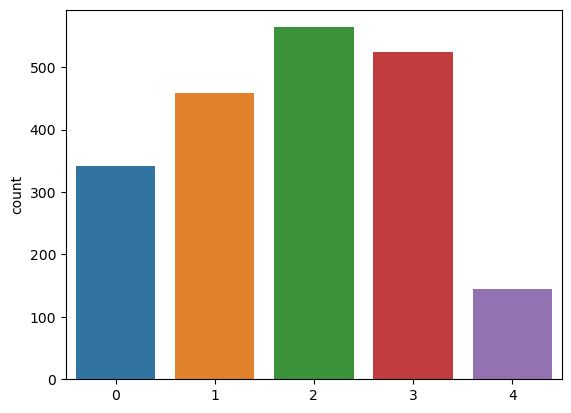

In [46]:
sns.countplot(x=labels)

In [47]:
nltk.download("stopwords")

def text_preprocessing(s):
    s = s.lower()
    # Change 't to 'not'
    s = re.sub(r"\'t", " not", s)
    # Isolate and remove punctuations except '?'
    s = re.sub(r'([\'\"\.\(\)\!\?\\\/\,])', r'  ', s)
    s = re.sub(r'[^\w\s\?]', ' ', s)
    # Remove some special characters
    s = re.sub(r'([\;\:\|•«\n])', ' ', s)
    # Remove stopwords except 'not' and 'can'
    s = " ".join([word for word in s.split()
                  if word not in stopwords.words('english')
                  or word in ['not', 'can']])
    # Remove trailing whitespace
    s = re.sub(r'\s+', ' ', s).strip()
    
    return s

# Preprocess text
sentiments = np.array([text_preprocessing(text) for text in sentiments])

[nltk_data] Downloading package stopwords to C:\Users\Siddh
[nltk_data]     Sanghvi\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [48]:
def encoding_process(_content):
    tokenizer = BertTokenizer.from_pretrained('bert-base-uncased', do_lower_case=True)
    get_ids = []    
    for text in _content:
        input_ids = tokenizer.encode(
                        text,                      
                        add_special_tokens = True,
                        max_length = 256,
                        pad_to_max_length = True, 
                        return_tensors = 'pt')
        get_ids.append(input_ids)    
    
    get_ids = torch.cat(get_ids, dim=0)
    return get_ids

input_ids = encoding_process(sentiments).to(device)
input_ids

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.


tensor([[  101,  2498,  3563,  ...,     0,     0,     0],
        [  101,  2498,  6719,  ...,     0,     0,     0],
        [  101, 15030,  6583,  ...,     0,     0,     0],
        ...,
        [  101,  2498,  3563,  ...,     0,     0,     0],
        [  101,  2968,  3277,  ...,     0,     0,     0],
        [  101,  2498, 18959,  ...,     0,     0,     0]], device='cuda:0')

In [49]:
attention_masks = []
for seq in input_ids:
    seq_mask = [float(i>0) for i in seq]
    attention_masks.append(seq_mask)

In [50]:
labels = labels.to_numpy()
labels

array([2, 0, 0, ..., 2, 1, 3])

In [51]:
attention_masks = np.array(attention_masks)
attention_masks

array([[1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       ...,
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.],
       [1., 1., 1., ..., 0., 0., 0.]])

In [52]:
train_inputs, validation_inputs, train_labels, validation_labels = train_test_split(input_ids, labels, random_state=42, test_size=0.1)
train_masks, validation_masks,_ , _ = train_test_split(attention_masks, labels, random_state=42, test_size=0.1)

In [53]:
train_labels = torch.from_numpy(train_labels).to(device)
validation_labels = torch.from_numpy(validation_labels).to(device)

train_masks = torch.from_numpy(train_masks).to(device)
validation_masks = torch.from_numpy(validation_masks).to(device)

In [54]:
batch_size = 32

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_dataloader = DataLoader(train_data, sampler=RandomSampler(train_data), batch_size=batch_size)

validation_data = TensorDataset(validation_inputs, validation_inputs, validation_inputs)
validation_dataloader = DataLoader(validation_data, sampler=SequentialSampler(train_data), batch_size=batch_size)

In [55]:
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=5)
model.to(device)
model

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12,

In [56]:
parameter_optimizer =  list(model.named_parameters())
no_decay = ['bias', 'LayerNorm.weight', 'LayerNorm.weight']

optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if p.requires_grad and not any(nd in n for nd in no_decay)], 'weight_decay': 0.1},
    {'params': [p for n, p in model.named_parameters() if p.requires_grad and any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
]

In [57]:
optimizer = AdamW(params=model.parameters(), lr=2e-5)
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [58]:
from tqdm import trange
t = [] 
train_loss_set = []
epochs = 4

predictions = []
true_labels = []

eval_accuracy = 0
nb_eval_steps = 0
for epoch in trange(epochs, desc="Epoch"):
    model.eval()  # Put model in evaluation mode
    eval_accuracy = 0
    nb_eval_steps = 0
    predictions = []
    true_labels = []
    
    for batch in train_dataloader:
        batch = tuple(t.to(device) for t in batch)
        b_input_ids, b_input_mask, b_labels = batch
        
        with torch.no_grad():
            outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
            logits = outputs.logits
        
        logits = logits.detach().cpu().numpy()
        label_ids = b_labels.to('cpu').numpy()
        
        tmp_eval_accuracy = flat_accuracy(logits, label_ids)
        predictions.append(logits)
        true_labels.append(label_ids)
        eval_accuracy += tmp_eval_accuracy
        nb_eval_steps += 1
    
    print("Validation Accuracy for epoch {}: {}".format(epoch, eval_accuracy / nb_eval_steps))

Epoch:  25%|██▌       | 1/4 [01:09<03:28, 69.58s/it]

Validation Accuracy for epoch 0: 0.16756465517241378


Epoch:  50%|█████     | 2/4 [02:22<02:22, 71.32s/it]

Validation Accuracy for epoch 1: 0.16756465517241378


Epoch:  75%|███████▌  | 3/4 [03:41<01:15, 75.10s/it]

Validation Accuracy for epoch 2: 0.16379310344827586


Epoch: 100%|██████████| 4/4 [05:06<00:00, 76.61s/it]

Validation Accuracy for epoch 3: 0.17510775862068967
